In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import seaborn as sns
import os
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import plotly.express as px
import warnings

warnings.simplefilter("ignore")

In [2]:
# Load the data
data = pd.read_csv("/content/fer2013.csv")
print("Data shape:", data.shape)

Data shape: (35887, 3)


In [3]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
data['emotion'].value_counts()

,count
emotion,
3,8989
6,6198
4,6077
2,5121
0,4953
5,4002
1,547


In [5]:
# Check for missing values
print("Missing values:", data.isnull().sum())

Missing values: emotion    0
pixels     0
Usage      0
dtype: int64


In [6]:
# Class label distribution
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
fig = px.bar(
    x=CLASS_LABELS,
    y=[list(data['emotion']).count(i) for i in np.unique(data['emotion'])],
    color=np.unique(data['emotion']),
    color_continuous_scale="Emrld"
)
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title="Number of Images")
fig.update_layout(title="Train Data Distribution")
fig.show()

In [7]:
# Shuffle and one-hot encode labels
data = data.sample(frac=1)
labels = to_categorical(data['emotion'], num_classes=7)

In [8]:
# Process image data
train_pixels = np.array(data["pixels"].str.split(" ").tolist(), dtype=np.uint8)
pixels = train_pixels.reshape((35887*2304, 1))

In [9]:
# Standardize the pixel values
scaler = StandardScaler()
pixels = scaler.fit_transform(pixels).reshape((35887, 48, 48, 1))

In [10]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)
print(f"Train: {X_train.shape}, Test: {X_test.shape}, Validation: {X_val.shape}")

Train: (29068, 48, 48, 1), Test: (3589, 48, 48, 1), Validation: (3230, 48, 48, 1)


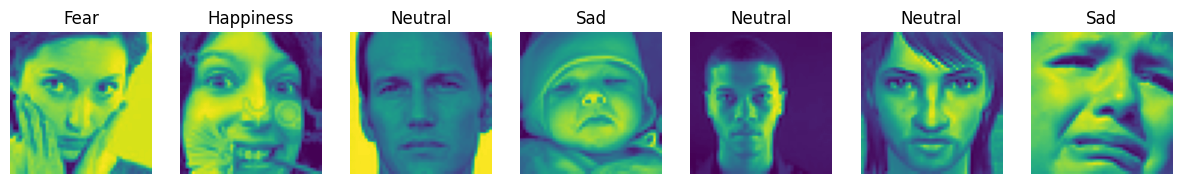

In [11]:
plt.figure(figsize=(15,23))
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
i = 1
for i in range (7):
    img = np.squeeze(X_train[i])
    plt.subplot(1,7,i+1)
    plt.imshow(img)
    index = np.argmax(y_train[i])
    plt.title(label_dict[index])
    plt.axis('off')
    i += 1
plt.show()

In [12]:
# Data Augmentation
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=False, zoom_range=0.0)
valgen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=False, zoom_range=0.0)
datagen.fit(X_train)
valgen.fit(X_val)
train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = valgen.flow(X_val, y_val, batch_size=64)

In [13]:
# Define the CNN model
def cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)),
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        #Dropout(0.25),

        Conv2D(64, (3, 3), padding='same', activation='relu'),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        #Dropout(0.25),

        Conv2D(128, (3, 3), padding='same', activation='relu', dilation_rate=(2, 2)),
        Conv2D(128, (3, 3), padding='same', activation='relu', dilation_rate=(2, 2)),
        MaxPooling2D((2, 2)),
        #Dropout(0.25),

        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.25),

        Dense(512, activation='relu'),
        Dropout(0.25),

        Dense(7, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [14]:
model = cnn_model()

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         294,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │          33,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 618,279 (2.36 MB)

 Trainable params: 618,279 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Callbacks for early stopping and model checkpointing
checkpointer = [
    EarlyStopping(monitor='val_accuracy', verbose=1, restore_best_weights=True, mode="max", patience=5),
    ModelCheckpoint('best_model.keras', monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")
]

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    batch_size=64,
    verbose=1,
    callbacks=checkpointer,
    validation_data=val_generator
)

Epoch 1/20
233/455 ━━━━━━━━━━━━━━━━━━━━ 4:03 1s/step - accuracy: 0.2149 - loss: 1.8622

In [ ]:
# Plot training history
plt.plot(history.history["loss"], 'r', label="Training Loss")
plt.plot(history.history["val_loss"], 'b', label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history["accuracy"], 'r', label="Training Accuracy")
plt.plot(history.history["val_accuracy"], 'b', label="Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
# Evaluate and predict
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

In [ ]:
preds = model.predict(X_test)
y_pred = np.argmax(preds, axis=1)

In [ ]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]

    ax.set_title("{} ({})".format((predict_index),
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

In [ ]:
# Confusion matrix and classification report
cm_data = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index=CLASS_LABELS)
plt.figure(figsize=(15,10))
sns.heatmap(cm, cmap="Blues", annot=True, fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(np.argmax(y_test, axis=1), y_pred, digits=3))